Find frequences of syntactic units for the texts. 

Compare distributions for different CEFR levels


In [1]:
# libraries
import spacy
import pandas as pd
import numpy as np
import re
import scipy.stats as st
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np

# load language model
nlp = spacy.load("en_core_web_sm")

In [2]:
# functions to create PoS features and syntactic features

def get_rounded_float(float_number):
    return float("{:.2f}".format(float_number))

# function for annotating text and getting pos tags
def get_pos(text):
    
    # annotate text
    annotated_text = nlp(text)
    
    # number of tokens
    total = len([token for token in annotated_text])
    
    # dictionary to store pos distribution
    pos_tags = {}
      
    for token in annotated_text:
        
        # count pos tags
        if token.pos_ in pos_tags.keys():
            pos_tags[token.pos_] += 1
        else:
            pos_tags[token.pos_] = 1
    
    # dictionary to store relative pos distribution
    proportion = {}
    
    for x, y in pos_tags.items():
        proportion[x] = y / total
    
    return proportion


In [3]:
# load dataset (dataset accessible here: https://www.kaggle.com/amontgomerie/cefr-levelled-english-texts)
data = pd.read_csv('/Users/rickardramhoj/ironhack_assignments/cefr_leveled_texts.csv')

# check data
print(data.head())


                                                text label
0  Hi!\nI've been meaning to write for ages and f...    B2
1  ﻿It was not so much how hard people found the ...    B2
2  Keith recently came back from a trip to Chicag...    B2
3  The Griffith Observatory is a planetarium, and...    B2
4  -LRB- The Hollywood Reporter -RRB- It's offici...    B2


In [4]:
# check if it's a balanced dataset with value_counts
print(data.label.value_counts())


A1    288
B2    286
A2    272
C1    241
B1    205
C2    202
Name: label, dtype: int64


In [5]:
# create new column with pos distribution
data["pos_dist"] = data["text"].apply(get_pos)


In [6]:
# function to preprocess text
def clean_text(text):

    # remove punctuation, numbers and weird spacing and lowercase
    return re.sub(r'[^\w\s]','', text).lower()

# preprocess text
data["cleaned_text"] = data["text"].apply(clean_text)

data.head()

,text,label,pos_dist,cleaned_text
0,Hi!\nI've been meaning to write for ages and f...,B2,"{'INTJ': 0.0018656716417910447, 'PUNCT': 0.100...",hi\nive been meaning to write for ages and fin...
1,﻿It was not so much how hard people found the ...,B2,"{'NOUN': 0.1685823754789272, 'AUX': 0.04725415...",it was not so much how hard people found the c...
2,Keith recently came back from a trip to Chicag...,B2,"{'PROPN': 0.13653136531365315, 'ADV': 0.025830...",keith recently came back from a trip to chicag...
3,"The Griffith Observatory is a planetarium, and...",B2,"{'DET': 0.15072463768115943, 'PROPN': 0.086956...",the griffith observatory is a planetarium and ...
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2,"{'PROPN': 0.1941747572815534, 'DET': 0.1043689...",lrb the hollywood reporter rrb its official am...


In [7]:

# flatten pos columns
data = pd.concat([data.drop(['pos_dist'], axis=1), data['pos_dist'].apply(pd.Series)], axis=1)



In [8]:
# fill NaN with 0
data = data.fillna(0)

data.head()


,text,label,cleaned_text,INTJ,PUNCT,SPACE,PRON,AUX,VERB,PART,...,NOUN,CCONJ,ADV,SCONJ,ADJ,DET,NUM,PROPN,SYM,X
0,Hi!\nI've been meaning to write for ages and f...,B2,hi\nive been meaning to write for ages and fin...,0.001866,0.100746,0.013060,0.104478,0.072761,0.139925,0.044776,...,0.106343,0.035448,0.091418,0.009328,0.055970,0.059701,0.009328,0.044776,0.000000,0.0
1,﻿It was not so much how hard people found the ...,B2,it was not so much how hard people found the c...,0.000000,0.107280,0.025543,0.067688,0.047254,0.139208,0.051086,...,0.168582,0.030651,0.062580,0.016603,0.066411,0.094508,0.017880,0.015326,0.000000,0.0
2,Keith recently came back from a trip to Chicag...,B2,keith recently came back from a trip to chicag...,0.000000,0.095941,0.011070,0.025830,0.025830,0.107011,0.033210,...,0.154982,0.022140,0.025830,0.011070,0.070111,0.143911,0.022140,0.136531,0.003690,0.0
3,"The Griffith Observatory is a planetarium, and...",B2,the griffith observatory is a planetarium and ...,0.000000,0.098551,0.005797,0.023188,0.043478,0.101449,0.026087,...,0.194203,0.034783,0.026087,0.002899,0.063768,0.150725,0.034783,0.086957,0.002899,0.0
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2,lrb the hollywood reporter rrb its official am...,0.002427,0.089806,0.021845,0.024272,0.048544,0.111650,0.016990,...,0.182039,0.031553,0.014563,0.009709,0.041262,0.104369,0.014563,0.194175,0.000000,0.0


In [9]:
# check for outliers and remove

# check shape of data
print(data.shape)

# list of tags
tag_list = ['ADV', 'NOUN', 'ADP', 'VERB', 'PRON', 'ADJ', 'PUNCT','PROPN', 'DET', 'PART', 'CCONJ', 'SPACE', 'AUX', 'NUM', 'SCONJ', 'INTJ', 'SYM', 'X']

# calculate z-scores
z_scores = st.zscore(data[tag_list])

# get absolute numbers
abs_z_scores = np.abs(z_scores)

# get filtered entries
filtered_entries = (abs_z_scores < 3).all(axis=1)

data = data[filtered_entries]

print(data.shape)

# check again for balance
print(data.label.value_counts())


(1494, 21)
(1267, 21)
B2    267
A2    236
C1    233
A1    178
B1    178
C2    175
Name: label, dtype: int64


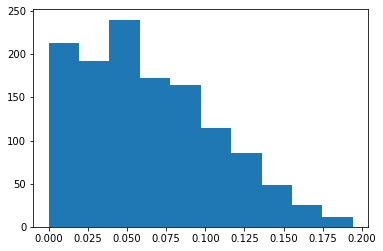

ADV: Sample does not look Gaussian (reject H0)
NOUN: Sample does not look Gaussian (reject H0)
ADP: Sample does not look Gaussian (reject H0)
VERB: Sample does not look Gaussian (reject H0)
PRON: Sample does not look Gaussian (reject H0)
ADJ: Sample looks Gaussian (fail to reject H0)
PUNCT: Sample does not look Gaussian (reject H0)
PROPN: Sample does not look Gaussian (reject H0)
DET: Sample does not look Gaussian (reject H0)
PART: Sample does not look Gaussian (reject H0)
CCONJ: Sample does not look Gaussian (reject H0)
SPACE: Sample does not look Gaussian (reject H0)
AUX: Sample does not look Gaussian (reject H0)
NUM: Sample does not look Gaussian (reject H0)
SCONJ: Sample does not look Gaussian (reject H0)
INTJ: Sample does not look Gaussian (reject H0)
SYM: Sample does not look Gaussian (reject H0)
X: Sample does not look Gaussian (reject H0)


In [10]:
# check for normality

# list of tags
tag_list = ['ADV', 'NOUN', 'ADP', 'VERB', 'PRON', 'ADJ', 'PUNCT','PROPN', 'DET', 'PART', 'CCONJ', 'SPACE', 'AUX', 'NUM', 'SCONJ', 'INTJ', 'SYM', 'X']

# check histogram
plt.hist(data[tag_list[7]])

plt.show()

# import Shapiro Wilkinson test
from scipy.stats import shapiro

for tag in tag_list:
    
    # normality test
    stat, p = shapiro(data[tag])
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'{tag}: Sample looks Gaussian (fail to reject H0)')
    else:
        print(f'{tag}: Sample does not look Gaussian (reject H0)')

In [11]:
# Homogeneity of variances
import pingouin as pg

# make copy of df
data_copy = data.copy()

# convert labels to numeric
data_copy["label"].replace({"A1": 1, "A2": 2, "B1": 3, "B2": 4, "C1": 5, "C2": 6}, inplace=True)

# list of tags
tag_list = ['ADV', 'NOUN', 'ADP', 'VERB', 'PRON', 'ADJ', 'PUNCT','PROPN', 'DET', 'PART', 'CCONJ', 'SPACE', 'AUX', 'NUM', 'SCONJ', 'INTJ', 'SYM', 'X']

# Levene's Test using Pingouin
for tag in tag_list:
    
    display(f"{tag}: {pg.homoscedasticity(data_copy, dv='label', group=tag)}")


/opt/anaconda3/envs/ironhack/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


'ADV:                W  pval  equal_var\nlevene  0.322516   1.0       True'

'NOUN:                W  pval  equal_var\nlevene  0.400024   1.0       True'

'ADP:                W  pval  equal_var\nlevene  0.414059   1.0       True'

'VERB:                W  pval  equal_var\nlevene  0.393056   1.0       True'

'PRON:                W  pval  equal_var\nlevene  0.323699   1.0       True'

'ADJ:                W  pval  equal_var\nlevene  0.339144   1.0       True'

'PUNCT:                W  pval  equal_var\nlevene  0.408199   1.0       True'

'PROPN:                W  pval  equal_var\nlevene  0.498403   1.0       True'

'DET:                W  pval  equal_var\nlevene  0.291363   1.0       True'

'PART:                W  pval  equal_var\nlevene  0.500423   1.0       True'

'CCONJ:               W      pval  equal_var\nlevene  0.70979  0.999939       True'

'SPACE:                W  pval  equal_var\nlevene  0.406935   1.0       True'

'AUX:                W  pval  equal_var\nlevene  0.345355   1.0       True'

'NUM:                W  pval  equal_var\nlevene  0.333017   1.0       True'

'SCONJ:                W  pval  equal_var\nlevene  0.466229   1.0       True'

'INTJ:                W          pval  equal_var\nlevene  1.556513  1.874267e-07      False'

'SYM:                W          pval  equal_var\nlevene  2.052836  5.442869e-15      False'

'X:                W      pval  equal_var\nlevene  1.935749  0.000004      False'

In [12]:
# Mann-Whitney U rank test on two independent samples as alternative to t-tests

# store results
mann_whitney_results = {}

# list of tags
tag_list = ['ADV', 'NOUN', 'ADP', 'VERB', 'PRON', 'ADJ', 'PUNCT','PROPN', 'DET', 'PART', 'CCONJ', 'SPACE', 'AUX', 'NUM', 'SCONJ', 'INTJ', 'SYM', 'X']

for tag in tag_list:
    try:
        A1_vs_A2 = {"stat": st.mannwhitneyu(data[data["label"] == 'A1'][tag], data[data["label"] == 'A2'][tag])[0], "pvalue": st.mannwhitneyu(data[data["label"] == 'A1'][tag], data[data["label"] == 'A2'][tag])[1] < 0.05}
        A2_vs_B1 = {"stat": st.mannwhitneyu(data[data["label"] == 'A2'][tag], data[data["label"] == 'B1'][tag])[0], "pvalue": st.mannwhitneyu(data[data["label"] == 'A2'][tag], data[data["label"] == 'B1'][tag])[1] < 0.05}
        B1_vs_B2 = {"stat": st.mannwhitneyu(data[data["label"] == 'B1'][tag], data[data["label"] == 'B2'][tag])[0], "pvalue": st.mannwhitneyu(data[data["label"] == 'B1'][tag], data[data["label"] == 'B2'][tag])[1] < 0.05}
        B2_vs_C1 = {"stat": st.mannwhitneyu(data[data["label"] == 'B2'][tag], data[data["label"] == 'C1'][tag])[0], "pvalue": st.mannwhitneyu(data[data["label"] == 'B2'][tag], data[data["label"] == 'C1'][tag])[1] < 0.05}
        C1_vs_C2 = {"stat": st.mannwhitneyu(data[data["label"] == 'C1'][tag], data[data["label"] == 'C2'][tag])[0], "pvalue": st.mannwhitneyu(data[data["label"] == 'C1'][tag], data[data["label"] == 'C2'][tag])[1] < 0.05}
    
        mann_whitney_results[tag] = {"A1 vs A2": A1_vs_A2, "A2 vs B1": A2_vs_B1, "B1 vs B2": B1_vs_B2, "B2 vs C1": B2_vs_C1, "C1 vs C2": C1_vs_C2}
    except:
        pass
pd.DataFrame(mann_whitney_results).T


,A1 vs A2,A2 vs B1,B1 vs B2,B2 vs C1,C1 vs C2
ADV,"{'stat': 16928.0, 'pvalue': True}","{'stat': 18772.5, 'pvalue': True}","{'stat': 19436.5, 'pvalue': True}","{'stat': 28136.5, 'pvalue': True}","{'stat': 18440.5, 'pvalue': True}"
NOUN,"{'stat': 20746.0, 'pvalue': False}","{'stat': 12364.0, 'pvalue': True}","{'stat': 21107.0, 'pvalue': True}","{'stat': 23896.5, 'pvalue': True}","{'stat': 15316.5, 'pvalue': True}"
ADP,"{'stat': 12830.0, 'pvalue': True}","{'stat': 10643.5, 'pvalue': True}","{'stat': 17720.0, 'pvalue': True}","{'stat': 27790.0, 'pvalue': True}","{'stat': 16864.0, 'pvalue': True}"
VERB,"{'stat': 14784.5, 'pvalue': True}","{'stat': 11089.5, 'pvalue': True}","{'stat': 18714.0, 'pvalue': True}","{'stat': 30469.0, 'pvalue': False}","{'stat': 14489.5, 'pvalue': True}"
PRON,"{'stat': 15230.5, 'pvalue': True}","{'stat': 7502.0, 'pvalue': True}","{'stat': 17586.0, 'pvalue': True}","{'stat': 23952.5, 'pvalue': True}","{'stat': 12607.0, 'pvalue': True}"
ADJ,"{'stat': 20023.0, 'pvalue': False}","{'stat': 12644.5, 'pvalue': True}","{'stat': 20228.0, 'pvalue': True}","{'stat': 25938.0, 'pvalue': True}","{'stat': 13366.0, 'pvalue': True}"
PUNCT,"{'stat': 9650.5, 'pvalue': True}","{'stat': 10628.0, 'pvalue': True}","{'stat': 21642.0, 'pvalue': False}","{'stat': 29264.0, 'pvalue': False}","{'stat': 14697.0, 'pvalue': True}"
PROPN,"{'stat': 13998.0, 'pvalue': True}","{'stat': 16013.5, 'pvalue': True}","{'stat': 18308.5, 'pvalue': True}","{'stat': 28828.5, 'pvalue': False}","{'stat': 17941.5, 'pvalue': True}"
DET,"{'stat': 20741.5, 'pvalue': False}","{'stat': 12679.5, 'pvalue': True}","{'stat': 23294.0, 'pvalue': False}","{'stat': 31037.5, 'pvalue': False}","{'stat': 20264.5, 'pvalue': False}"
PART,"{'stat': 16162.5, 'pvalue': True}","{'stat': 17138.5, 'pvalue': True}","{'stat': 21616.5, 'pvalue': False}","{'stat': 30824.5, 'pvalue': False}","{'stat': 17283.5, 'pvalue': True}"


In [13]:
# ANOVA tests per PoS tag

# list of tags
tag_list = ['ADV', 'NOUN', 'ADP', 'VERB', 'PRON', 'ADJ', 'PUNCT','PROPN', 'DET', 'PART', 'CCONJ', 'SPACE', 'AUX', 'NUM', 'SCONJ', 'INTJ', 'SYM', 'X']

anova_results = {}

for tag in tag_list:
    
    # anova
    anova_results[tag] = st.f_oneway(data[data["label"] == 'A1'][tag], data[data["label"] == 'A2'][tag], data[data["label"] == 'B1'][tag], data[data["label"] == 'B2'][tag], data[data["label"] == 'C1'][tag], data[data["label"] == 'C2'][tag])[1] < 0.05

print(anova_results)

{'ADV': True, 'NOUN': True, 'ADP': True, 'VERB': True, 'PRON': True, 'ADJ': True, 'PUNCT': True, 'PROPN': True, 'DET': True, 'PART': True, 'CCONJ': True, 'SPACE': True, 'AUX': True, 'NUM': True, 'SCONJ': True, 'INTJ': True, 'SYM': True, 'X': True}


In [14]:
# multiple tests of independence

# store results
ttest_results = {}

# list of tags
tag_list = ['ADV', 'NOUN', 'ADP', 'VERB', 'PRON', 'ADJ', 'PUNCT','PROPN', 'DET', 'PART', 'CCONJ', 'SPACE', 'AUX', 'NUM', 'SCONJ', 'INTJ', 'SYM', 'X']

for tag in tag_list:
    
    A1_vs_A2 = {"stat": ttest_ind(data[data["label"] == 'A1'][tag], data[data["label"] == 'A2'][tag], equal_var=True)[0], "pvalue": ttest_ind(data[data["label"] == 'A1'][tag], data[data["label"] == 'A2'][tag], equal_var=True)[1] < 0.05}
    A2_vs_B1 = {"stat": ttest_ind(data[data["label"] == 'A2'][tag], data[data["label"] == 'B1'][tag], equal_var=True)[0], "pvalue": ttest_ind(data[data["label"] == 'A2'][tag], data[data["label"] == 'B1'][tag], equal_var=True)[1] < 0.05}
    B1_vs_B2 = {"stat": ttest_ind(data[data["label"] == 'B1'][tag], data[data["label"] == 'B2'][tag], equal_var=True)[0], "pvalue": ttest_ind(data[data["label"] == 'B1'][tag], data[data["label"] == 'B2'][tag], equal_var=True)[1] < 0.05}
    B2_vs_C1 = {"stat": ttest_ind(data[data["label"] == 'B2'][tag], data[data["label"] == 'C1'][tag], equal_var=True)[0], "pvalue": ttest_ind(data[data["label"] == 'B2'][tag], data[data["label"] == 'C1'][tag], equal_var=True)[1] < 0.05}
    C1_vs_C2 = {"stat": ttest_ind(data[data["label"] == 'C1'][tag], data[data["label"] == 'C2'][tag], equal_var=True)[0], "pvalue": ttest_ind(data[data["label"] == 'C1'][tag], data[data["label"] == 'C2'][tag], equal_var=True)[1] < 0.05}
    
   
    ttest_results[tag] = {"A1 vs A2": A1_vs_A2, "A2 vs B1": A2_vs_B1, "B1 vs B2": B1_vs_B2, "B2 vs C1": B2_vs_C1, "C1 vs C2": C1_vs_C2}

pd.DataFrame(ttest_results).T

,A1 vs A2,A2 vs B1,B1 vs B2,B2 vs C1,C1 vs C2
ADV,"{'stat': -2.9643395085700788, 'pvalue': True}","{'stat': 1.6188710897488239, 'pvalue': False}","{'stat': 2.8722945729391496, 'pvalue': True}","{'stat': 2.1628657727955787, 'pvalue': True}","{'stat': 1.6195721346855672, 'pvalue': False}"
NOUN,"{'stat': -0.03192101120789628, 'pvalue': False}","{'stat': -7.224658417737115, 'pvalue': True}","{'stat': -0.7511046038075772, 'pvalue': False}","{'stat': -3.814801973514762, 'pvalue': True}","{'stat': -4.929471343962148, 'pvalue': True}"
ADP,"{'stat': -6.803898008635511, 'pvalue': True}","{'stat': -8.837204306424637, 'pvalue': True}","{'stat': -4.869177835795646, 'pvalue': True}","{'stat': -2.296359079345142, 'pvalue': True}","{'stat': -2.895518614452677, 'pvalue': True}"
VERB,"{'stat': -5.571535571692135, 'pvalue': True}","{'stat': 8.840550932926465, 'pvalue': True}","{'stat': 3.5046792984954473, 'pvalue': True}","{'stat': 0.5519225267914604, 'pvalue': False}","{'stat': 5.697319583278836, 'pvalue': True}"
PRON,"{'stat': 4.621652574075059, 'pvalue': True}","{'stat': 13.287570387102594, 'pvalue': True}","{'stat': 5.366686135308078, 'pvalue': True}","{'stat': 4.587618823294162, 'pvalue': True}","{'stat': 7.100271563217254, 'pvalue': True}"
ADJ,"{'stat': 1.4414539593434965, 'pvalue': False}","{'stat': -7.3503094781961495, 'pvalue': True}","{'stat': -2.8594938507379104, 'pvalue': True}","{'stat': -3.400773452960195, 'pvalue': True}","{'stat': -6.315559218137619, 'pvalue': True}"
PUNCT,"{'stat': 10.445126052174572, 'pvalue': True}","{'stat': 8.91153902188201, 'pvalue': True}","{'stat': 1.9829275632406076, 'pvalue': True}","{'stat': 0.7943217810159326, 'pvalue': False}","{'stat': -5.6739384215407735, 'pvalue': True}"
PROPN,"{'stat': -5.494083169712226, 'pvalue': True}","{'stat': -5.04746720163593, 'pvalue': True}","{'stat': -3.857385410273651, 'pvalue': True}","{'stat': 1.278269291783073, 'pvalue': False}","{'stat': 2.150465652238882, 'pvalue': True}"
DET,"{'stat': 0.16325895129748672, 'pvalue': False}","{'stat': -6.7543984747995625, 'pvalue': True}","{'stat': 0.34619848454405333, 'pvalue': False}","{'stat': 0.2945194094546679, 'pvalue': False}","{'stat': 0.27245438114531445, 'pvalue': False}"
PART,"{'stat': -3.848463665647467, 'pvalue': True}","{'stat': 3.0435282391968244, 'pvalue': True}","{'stat': 1.5691602342103774, 'pvalue': False}","{'stat': 0.4171859815383805, 'pvalue': False}","{'stat': 2.881397876360538, 'pvalue': True}"


In [15]:
# confidence intervals

# list of tags
tag_list = ['ADV', 'NOUN', 'ADP', 'VERB', 'PRON', 'ADJ', 'PUNCT','PROPN', 'DET', 'PART', 'CCONJ', 'SPACE', 'AUX', 'NUM', 'SCONJ', 'INTJ', 'SYM', 'X']

results = {}

for tag in tag_list:
            

        A1 = data[data["label"] == "A1"][tag]
        A1_low, A1_high = st.t.interval(0.95, len(A1)-1, loc=np.mean(A1), scale=st.sem(A1))
        
        A2 = data[data["label"] == "A2"][tag]
        A2_low, A2_high = st.t.interval(0.95, len(A2)-1, loc=np.mean(A2), scale=st.sem(A2))
        
        B1 = data[data["label"] == "B1"][tag]
        B1_low, B1_high = st.t.interval(0.95, len(B1)-1, loc=np.mean(B1), scale=st.sem(B1))
        
        B2 = data[data["label"] == "B2"][tag]
        B2_low, B2_high = st.t.interval(0.95, len(B2)-1, loc=np.mean(B2), scale=st.sem(B2))
        
        C1 = data[data["label"] == "C1"][tag]
        C1_low, C1_high = st.t.interval(0.95, len(C1)-1, loc=np.mean(C1), scale=st.sem(C1))
        
        C2 = data[data["label"] == "C2"][tag]
        C2_low, C2_high = st.t.interval(0.95, len(C2)-1, loc=np.mean(C2), scale=st.sem(C2))
        

        results[tag] = {"A1": (A1_low, A1_high), "A2": (A2_low, A2_high), "B1": (B1_low, B1_high), "B2": (B2_low, B2_high), "C1": (C1_low, C1_high), "C2": (C2_low, C2_high)}
    

pd.DataFrame(results)




/opt/anaconda3/envs/ironhack/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/anaconda3/envs/ironhack/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,ADV,NOUN,ADP,VERB,PRON,ADJ,PUNCT,PROPN,DET,PART,CCONJ,SPACE,AUX,NUM,SCONJ,INTJ,SYM,X
A1,"(0.03727084334682961, 0.044090388199312124)","(0.14143830093432563, 0.1573761116212934)","(0.05539899480087109, 0.06447732788724378)","(0.12360707506826994, 0.13302921725677447)","(0.1316532406831839, 0.14375186308992416)","(0.04291060643164326, 0.05054765824938979)","(0.16361218880718845, 0.1738632277085759)","(0.024142880950528238, 0.0332541392986193)","(0.07597202627329924, 0.08645978788521283)","(0.023845103188326968, 0.029212602785651177)","(0.008546888029754337, 0.011510157065865497)","(0.030963882733127276, 0.04484615327457053)","(0.058460049135521, 0.06609722565523983)","(0.007108410218735566, 0.011189295378366479)","(0.0039844429923211865, 0.00588003359724132)","(0.006033736652476097, 0.009026522948916623)","(2.572849288476174e-05, 0.00041388935851620974)","(nan, nan)"
A2,"(0.04437791764830449, 0.04927002873790024)","(0.144076626531295, 0.15504102754876897)","(0.07501832237162126, 0.08101524582781677)","(0.14074951217858295, 0.1472768144012353)","(0.11519591750290484, 0.12468292512986565)","(0.041195136221508305, 0.0459679705565612)","(0.13205677064351448, 0.1395880258278204)","(0.04221806999556599, 0.05102331459996813)","(0.07740829793710834, 0.08403967690987384)","(0.03088068588769694, 0.03472982576383069)","(0.022486349955985818, 0.025844016600890574)","(0.016240481599774797, 0.023541655783018808)","(0.04988091258465234, 0.05490619050908685)","(0.00856408163866673, 0.011075033782369107)","(0.010496399941919237, 0.012634556736872131)","(0.0030644914025442, 0.0047224315447942115)","(0.0001691556003760333, 0.0005621300973053834)","(nan, nan)"
B1,"(0.041430174335071256, 0.04639293943682311)","(0.17347159834150563, 0.18530567877643636)","(0.09385742337190357, 0.09895513918419054)","(0.11874278890509223, 0.12579812297508017)","(0.06769503625503463, 0.07778640915812375)","(0.054499443070047025, 0.060166159402515025)","(0.1093802518706108, 0.11575160170834019)","(0.0598458840006452, 0.07375402237724371)","(0.09403437083404705, 0.10124197790108479)","(0.026642803007753995, 0.030438939072698904)","(0.024576457676168853, 0.027503037072065993)","(0.014427048410624824, 0.018956128891380722)","(0.04758576258692933, 0.0513748340198842)","(0.014967147327106356, 0.018657656354883402)","(0.010776001447351849, 0.012774790457764586)","(0.0006390667300261791, 0.0012848958281290353)","(0.0003297026318438021, 0.0007898642803803347)","(2.3351715527736163e-05, 0.00014349058568485895)"
B2,"(0.037702854321631875, 0.04134217744866365)","(0.17826054580741232, 0.18551840442966058)","(0.1024056180370219, 0.10649383046295167)","(0.11275709163513156, 0.11739759389902577)","(0.054127332502647264, 0.060488007550989924)","(0.0601973633043146, 0.06403444376569281)","(0.10666779494683189, 0.11099446973644107)","(0.07827865762977458, 0.0886294774229583)","(0.09439603958442762, 0.0993896957574155)","(0.025252023266101573, 0.028108560628457343)","(0.026328051689317476, 0.028190239818721236)","(0.017800176231052955, 0.02121713311232222)","(0.043614747350576355, 0.046532530926842744)","(0.017702838284649802, 0.020656570174191625)","(0.010302389702848778, 0.011690269673198327)","(0.0005460247447717877, 0.000943174122406179)","(0.0006598577793724438, 0.0011857838212658448)","(4.370062758308589e-05, 0.00014452980332741035)"
C1,"(0.03513859793594987, 0.0384458125363753)","(0.18819620124696312, 0.1948032473372977)","(0.10583238890422753, 0.10964896015807793)","(0.11230089383515654, 0.11613710521631485)","(0.04456190085471865, 0.05011417185581215)","(0.06493073657916773, 0.06930484077691476)","(0.10500081081351495, 0.110007013648595)","(0.073498552747782, 0.08386034247711804)","(0.09426791948023616, 0.09852167952239543)","(0.025171986352859662, 0.027404474333641623)","(0.02672616518529686, 0.028959557121477023)","(0.019597057173975568, 0.022503382796258433)","(0.042165075519135384, 0.045043753140506265)","(0.018020339736194563, 0.020868847065099953)","(0.011717713291583444, 

,label,INTJ,PUNCT,SPACE,PRON,AUX,VERB,PART,ADP,NOUN,CCONJ,ADV,SCONJ,ADJ,DET,NUM,PROPN,SYM,X
label,1.000000,-0.275947,-0.445907,0.212836,-0.750105,-0.370845,-0.417777,-0.121304,0.612500,0.459612,0.416171,-0.183294,0.280159,0.497920,0.237395,0.358055,0.378923,0.283714,0.215607
INTJ,-0.275947,1.000000,0.274952,0.286509,0.341314,0.201568,0.170594,0.130506,-0.347064,-0.421210,-0.069944,0.211688,-0.025551,-0.241556,-0.339156,-0.160806,-0.153462,-0.007907,0.013244
PUNCT,-0.445907,0.274952,1.000000,-0.251573,0.437468,0.145486,0.097797,-0.152149,-0.484377,-0.303231,-0.260396,0.104465,-0.276362,-0.211726,-0.246950,-0.235465,-0.350578,-0.148505,0.028342
SPACE,0.212836,0.286509,-0.251573,1.000000,-0.168887,0.012538,-0.147202,0.037436,0.017725,-0.136273,0.040715,-0.047075,0.001547,-0.026713,-0.253946,0.166438,0.225239,0.190187,0.068725
PRON,-0.750105,0.341314,0.437468,-0.168887,1.000000,0.380952,0.569547,0.232278,-0.605287,-0.554046,-0.287232,0.274565,-0.139338,-0.478405,-0.425521,-0.494650,-0.530299,-0.230787,-0.160428
AUX,-0.370845,0.201568,0.145486,0.012538,0.380952,1.000000,0.217479,0.247429,-0.461025,-0.369368,-0.194928,0.288772,0.088613,-0.202811,-0.207983,-0.268910,-0.337980,-0.145581,-0.127464
VERB,-0.417777,0.170594,0.097797,-0.147202,0.569547,0.217479,1.000000,0.490589,-0.475996,-0.324325,-0.079651,0.233922,0.104095,-0.486623,-0.315833,-0.418154,-0.396794,-0.141977,-0.161604
PART,-0.121304,0.130506,-0.152149,0.037436,0.232278,0.247429,0.490589,1.000000,-0.290132,-0.261255,0.019157,0.214119,0.180728,-0.198294,-0.290204,-0.238852,-0.149352,-0.020206,-0.074394
ADP,0.612500,-0.347064,-0.484377,0.017725,-0.605287,-0.461025,-0.475996,-0.290132,1.000000,0.397461,0.204802,-0.261539,0.097558,0.313968,0.327288,0.386167,0.414483,0.173646,0.117947
NOUN,0.459612,-0.421210,-0.303231,-0.136273,-0.554046,-0.369368,-0.324325,-0.261255,0.397461,1.000000,0.149845,-0.321987,0.014842,0.329509,0.426898,0.203999,-0.069023,0.100682,0.082225


<AxesSubplot:>

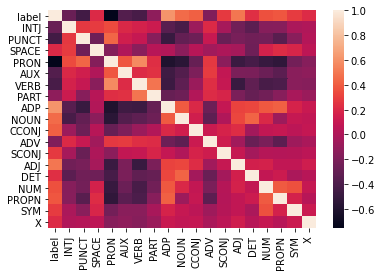

In [16]:
# Correlation matrix

# import library
import seaborn as sns
%matplotlib inline

# make copy of df
data_copy = data.copy()

# convert labels to numeric
data_copy["label"].replace({"A1": 1, "A2": 2, "B1": 3, "B2": 4, "C1": 5, "C2": 6}, inplace=True)

# correlations
corr = data_copy.corr(method="spearman")

display(corr)

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


Precision: 0.5810552374135052
Recall: 0.5708661417322834
F1 score: 0.5677515604602611


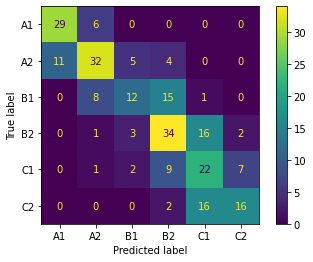

In [18]:
# Multiclass logistic regression analysis

# make copy of df
data_copy = data.copy()

# define features
features = data_copy[['cleaned_text','ADV', 'NOUN', 'ADP', 'VERB', 'PRON', 'ADJ', 'PUNCT','PROPN', 'DET', 'PART', 'CCONJ', 'AUX', 'SCONJ', 'INTJ']]

# define numeric variables
numeric_features = ['ADV', 'NOUN', 'ADP', 'VERB', 'PRON', 'ADJ', 'PUNCT','PROPN', 'DET', 'PART', 'CCONJ', 'AUX', 'SCONJ', 'INTJ']

# define labels
labels = data_copy[["label"]]

# define vectorizer
vectorizer = TfidfVectorizer()

# define scaler
scaler = preprocessing.StandardScaler()

# construct the column transfomer
column_transformer = ColumnTransformer([('text', vectorizer, 'cleaned_text'), ("num", scaler, numeric_features)])

# create logistic model
model = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# fit the model
pipe = Pipeline([('column_transformer', column_transformer),('classify', model)])

# split variables in train and test
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=10)

# fit model
pipe.fit(features_train, labels_train.values.ravel())

# display metrics
precision, recall, fbeta_score, support = precision_recall_fscore_support(labels_test, pipe.predict(features_test), average="weighted")

print("Precision:", precision)

print("Recall:", recall)

print("F1 score:", fbeta_score)

plot_confusion_matrix(pipe, features_test, labels_test)

plt.show()

